# Overview

This explores the transfer learning of Resnet-50 as the encoder for the U-Net architecture on the chest pneumonia dataset

# Environment

The following lines of code will configure your Google Colab environment for this tutorial.

### Enable GPU runtime

Use the following instructions to switch the default Colab instance into a GPU-enabled runtime:

```
Runtime > Change runtime type > Hardware accelerator > GPU
```

### Jarvis library

In this notebook we will Jarvis, a custom Python package to facilitate data science and deep learning for healthcare. Among other things, this library will be used for low-level data management, stratification and visualization of high-dimensional medical data.

In [2]:
# --- Install Jarvis library
%pip install jarvis-md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 732.5 kB/s eta 0:00:00


### Imports

Use the following lines to import any needed libraries:

In [3]:
import numpy as np
import tensorflow_hub as hub
from tensorflow.keras import Input, Model, models, layers, losses, metrics, optimizers
from jarvis.train import datasets
from jarvis.utils.display import imshow, montage
from tensorflow.keras.applications import ResNet50
import tensorflow as tf

# Data

The data used in this tutorial will consist of (frontal projection) chest radiographs from a subset of the RSNA / Kaggle pneumonia challenge (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge). From the complete cohort, a random subset of 1,000 exams will be used for training and evaluation.

### Download

The custom `datasets.download(...)` method can be used to download a local copy of the dataset. By default the dataset will be archived at `/data/raw/xr_pna`; as needed an alternate location may be specified using `datasets.download(name=..., path=...)`.

In [4]:
# --- Download dataset
datasets.download(name='xr/pna-512')

[ 2023-07-24 00:24:46 ] [====================] 100.000% : Extracting archive (0003015 / 0003015) 

{'code': '/data/raw/xr_pna', 'data': '/data/raw/xr_pna'}

### Python generators

Once the dataset is downloaded locally, Python generators to iterate through the dataset can be easily prepared using the `datasets.prepare(...)` method:

In [5]:
# --- Prepare generators
gen_train, gen_valid, client = datasets.prepare(name='xr/pna-512', keyword='seg-512')

The created generators, `gen_train` and `gen_valid`, are designed to yield two variables per iteration: `xs` and `ys`. Both `xs` and `ys` each represent a dictionary of NumPy arrays containing model input(s) and output(s) for a single *batch* of training. The use of Python generators provides a generic interface for data input for a number of machine learning libraries including Tensorflow 2 / Keras.

Note that any valid Python iterable method can be used to loop through the generators indefinitely. For example the Python built-in `next(...)` method will yield the next batch of data:

In [6]:
# --- Yield one example
xs, ys = next(gen_train)

### Preprocessing

The ResNet-50 backbone used for transfer learning in this experiment requires the following modifications:

* data input must be 2D (H X W) in shape
* data input must be 3 channels in depth
* data input must be scaled between `[0, 1]`

To implement this modifications, consider the following (nested) Python generator function:

In [40]:
#to subsample the data to make it smaller
a = 8

In [41]:
def generator(G):
  for xs, ys in G:

    #To keep the same distribution, we push all values to non-negative and divide by the highest value
    min = np.min(xs['dat'], axis = (1,2,3,4))
    min = min.reshape(8,1,1,1,1)
    xs['dat'] = xs['dat'] - min
    max = np.max(xs['dat'], axis = (1,2,3,4))
    max = max.reshape(8,1,1,1,1)
    xs['dat'] = xs['dat'] / max

    #Resnet input only take RGB inputs
    xs['dat'] = np.tile(xs['dat'].reshape([-1,512,512,1]), (1,1,1,3))
    xs['dat'] = xs['dat'].reshape([8, 512, 512, 3])

    #Resampling the dataset because it reaches the ram capacity
    xs['dat'] = xs['dat'][:, ::a, ::a, :]
    xs['pna'] = ys['pna'][:, 0, ::a, ::a, :]
    yield xs

Pass the default generators into our new generator function to complete the data preprocess step:

In [42]:
gen_train_pp = generator(gen_train)
gen_valid_pp = generator(gen_valid)

### Visualize

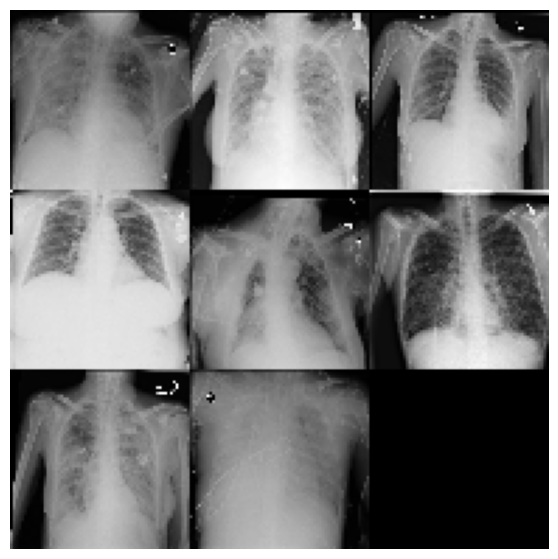

In [43]:
# --- Iterate next batch of data
xs = next(gen_train_pp)

# --- Use imshow(...) to visualize
imshow(xs['dat'])

# Model

This tutorial will explore pretrained ResNet-50 derivatives trained using the ImageNet.

Note that the ResNet model is implemented with a global average pool in the last convolutional layer; thus any 2D image of arbitrary shape H x W can be used as model input.

In [94]:
conv = lambda x, filters: layers.Conv2D(filters = filters, kernel_size = (3,3), padding = 'same', strides = 1)(x)
relu = lambda x : layers.LeakyReLU()(x)
norm = lambda x : layers.BatchNormalization()(x)
tran = lambda x, filters: layers.Conv2DTranspose(filters = filters, strides = 2, kernel_size = (3,3), padding = 'same')(x)


conv1 = lambda filters, x: relu(norm(conv(x, filters)))
tran1 = lambda filters, x: tran(x, filters)
concat = lambda x, y: layers.Concatenate()([x,y])

In [95]:
# --- Define model input
inputs = {'dat': Input(shape=(int(512/a), int(512/a), 3), dtype='float32')}

# --- Define pretrained model
pretrained = ResNet50(include_top = False, weights = 'imagenet', input_tensor = inputs['dat'])

#pretrained.summary()

In [96]:
l0 = pretrained(inputs['dat'])
l1 = tran1(1024, l0)
l2 = conv1(1024, concat(l1, pretrained.get_layer('conv4_block6_out').output)) #6x6

l3 = tran1(512, l2)
l4 = conv1(512, concat(l3, pretrained.get_layer('conv3_block4_out').output)) #12x2

l5 = tran1(256, l4)
l6 = conv1(256, concat(l5, pretrained.get_layer('conv2_block3_out').output)) #24x24

l7 = tran1(128, l6)
l8 = conv1(128, concat(l7, pretrained.get_layer('conv1_relu').output)) #48x48

l9 = tran1(64, l8)
outputs = layers.Conv2D(filters = 2, kernel_size = (3,3), strides = 1, padding = 'same')(l9)

backbone = Model(inputs = inputs, outputs = outputs)

In [97]:
inputs = {
    'dat': Input(shape=(int(512/a), int(512/a), 3), name='dat'),
    'pna': Input(shape=(int(512/a), int(512/a), 1), name='pna')}

In [98]:
# --- Define first step of new wrapper model
logits = backbone(inputs['dat'])

In [99]:
# # --- Define loss object
sce = losses.SparseCategoricalCrossentropy(from_logits=True)

# # --- Create loss tensor
loss = sce(y_true=inputs['pna'], y_pred=logits)

In [100]:
def calculate_dsc(y_true, y_pred, c=1):
    """
    Method to calculate the Dice score coefficient for given class

    :params

      y_true : ground-truth label
      y_pred : predicted logits scores
           c : class to calculate DSC on

    """
    true = y_true[..., 0] == c
    pred = tf.math.argmax(y_pred, axis=-1) == c

    A = tf.math.count_nonzero(true & pred) * 2
    B = tf.math.count_nonzero(true) + tf.math.count_nonzero(pred)

    return tf.math.divide_no_nan(
        tf.cast(A, tf.float32),
        tf.cast(B, tf.float32))

In [101]:
# --- Define Dice score
dsc = calculate_dsc(y_true=inputs['pna'], y_pred=logits)

# Model Training

### Compile model

In [102]:
training = Model(inputs=inputs, outputs={'logits': logits, 'loss': loss, 'dsc': dsc})

In [103]:
# --- Add loss
training.add_loss(loss)

# --- Add metric
training.add_metric(dsc, name='dsc')

In [104]:
# --- Define an Adam optimizer
optimizer = optimizers.Adam(learning_rate=2e-4)

# --- Compile model
training.compile(optimizer=optimizer)

### In-Memory Data

The following line of code will load all training data into RAM memory. This strategy can be effective for increasing speed of training for small to medium-sized datasets.

In [105]:
# --- Load data into memory
client.load_data_in_memory()

[ 2023-07-24 01:17:03 ] [====================] 100.000% : Iterating | 001000    

### Training

In [106]:
training.fit(
    x=gen_train_pp,
    steps_per_epoch=100,
    epochs=10,
    validation_data=gen_valid_pp,
    validation_steps=100,
    validation_freq=1)

Epoch 1/10
100/100 [==============================] - 79s 270ms/step - loss: 0.2101 - dsc: 0.5088 - val_loss: 0.7380 - val_dsc: 0.0262
Epoch 2/10
100/100 [==============================] - 24s 238ms/step - loss: 0.1269 - dsc: 0.6962 - val_loss: 0.4408 - val_dsc: 0.2835
Epoch 3/10
100/100 [==============================] - 24s 238ms/step - loss: 0.0942 - dsc: 0.7756 - val_loss: 0.2817 - val_dsc: 0.3280
Epoch 4/10
100/100 [==============================] - 24s 244ms/step - loss: 0.0731 - dsc: 0.8364 - val_loss: 0.2896 - val_dsc: 0.5069
Epoch 5/10
100/100 [==============================] - 22s 222ms/step - loss: 0.0591 - dsc: 0.8665 - val_loss: 0.2539 - val_dsc: 0.5845
Epoch 6/10
100/100 [==============================] - 25s 255ms/step - loss: 0.0508 - dsc: 0.8840 - val_loss: 0.2321 - val_dsc: 0.5653
Epoch 7/10
100/100 [==============================] - 24s 243ms/step - loss: 0.0403 - dsc: 0.9096 - val_loss: 0.2610 - val_dsc: 0.6029
Epoch 8/10
100/100 [==============================] - 2

Compare the results of the trained model segementation to the true values

1/1 [==============================] - 2s 2s/step


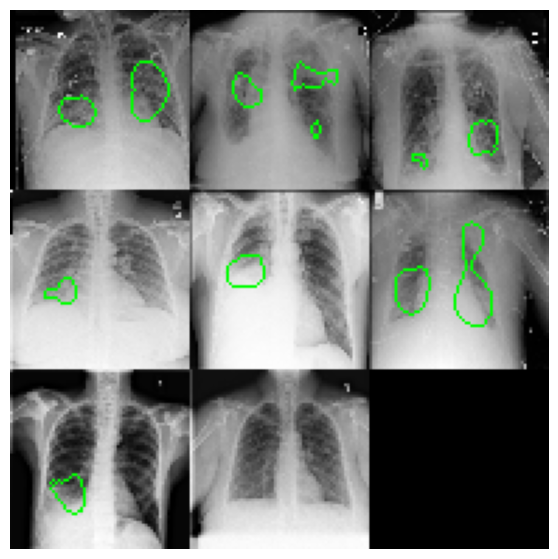

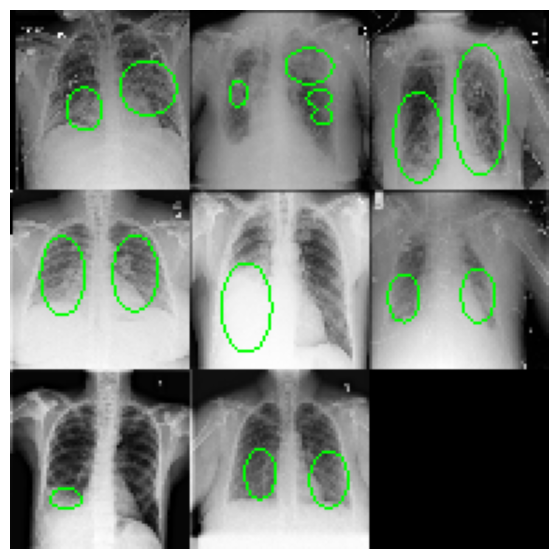

In [107]:
xs = next(gen_valid_pp)

results = training.predict(xs)
logits = np.argmax(results['logits'], axis = -1)

imshow(xs['dat'], logits)
imshow(xs['dat'], xs['pna'])